In [1]:
ENV["JULIA_CUDA_HARD_MEMORY_LIMIT"]="15GiB"

"15GiB"

In [1]:
# import Makie
# import CairoMakie
import MLDatasets
using Statistics: mean, std, var
using Random: bitrand
using ValueHistories: MVHistory, @trace
using RestrictedBoltzmannMachines: BinaryRBM, sample_from_inputs,
    initialize!, log_pseudolikelihood, pcd!, free_energy, sample_v_from_v
using Plots

using CudaRBMs
# using CudaRBMs: cpu, gpu
using CUDA

In [2]:
imggrid(A::AbstractArray{<:Any,4}) =
    reshape(permutedims(A, (1,3,2,4)), size(A,1)*size(A,3), size(A,2)*size(A,4))

imggrid (generic function with 1 method)

In [4]:
include("../utils/loader.jl")
include("../utils/structs.jl")

In [5]:
Random.seed!(1234);
hparams = HyperParams(nv=28*28, nh=400, batch_size=256, gpu_usage=true)

HyperParams
  nv: Int64 784
  nh: Int64 400
  batch_size: Int64 256
  lr: Float64 0.0002
  γ: Float64 0.001
  t: Int64 10
  gpu_usage: Bool true
  optType: String "SGD"


In [6]:
x = loadData(; hparams, dsName="MNIST01", numbers = [0,1,2,3,4,5,6,7,8,9], normalize=false, testset=false)
train_x = CuArray(reshape(hcat(x...),28,28,:));

[ Info: 60000


In [7]:
Int(floor(size(train_x,3)/500))

119

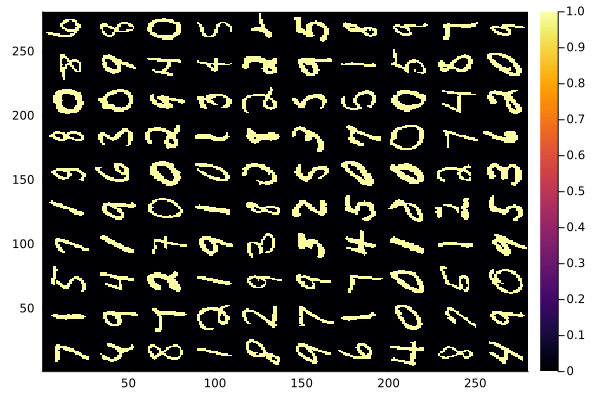

In [7]:
lnum = 10
samp = train_x[:,:,1:100] |> cpu;
heatmap(cat([cat([samp[:,:,i+j*lnum] for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [87]:
# train_x

In [8]:
rbm = CudaRBMs.gpu(BinaryRBM(Float32, (28,28), 500))
initialize!(rbm, train_x)

RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}(RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}([-13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; … ;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551]), RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}(Float32[0.0 0.0 … 0.0 0.0]), [-0.009278795 -0.009313305 … -0.006630962 0.009697584; 0.02003078 -0.0026384154 … -0.006283288 0.0039109606; … ; 0.0057423636 0.0031276252 … 0.014074835 0.00057990203; -0.0013064771 -0.0037913683 … -0.00994239 0.00925905;;; 0.027873771 -0.00465857 … -0.010048999 0.0033237012; 0.011186521

In [12]:
println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fcba7c4b850.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


 16.126965 seconds (7.94 M allocations: 576.404 MiB, 1.78% gc time)
log(PL) = -0.26510075


In [9]:
batchsize = 500 #256
iters = 10000
history = MVHistory()
@time pcd!(
    rbm, train_x; steps=100, iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            lpl = mean(log_pseudolikelihood(rbm, train_x))
            @trace history iter lpl
        end
    end
)


┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f5fbf09f850.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


1374.728636 seconds (433.86 M allocations: 23.918 GiB, 0.96% gc time, 0.01% compilation time: 38% of which was recompilation)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; … ;;; 6.0f-45 6.0f-45 … 0.0 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45], [1.52766f-11 3.40435f-13 … 1.89225f-13 2.62986f-13;;; 1.13876f-9 2.43373f-12 … 2.42029f-13 5.35095f-13;;; 1.26788f-12 3.67528f-12 … 9.91564f-12 1.9933f-13;;; … ;;; 3.6623f-13 5.69909f-13 … 0.0 2.52917f-10;;; 1.34001f-11 3.84631f-13 … 4.46703f-12 2.24646f-12;;; 2.97127f-13 1.08985f-12 … 5.51295f-11 3.37565f-12], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[0.0298738 0.0454102 … -0.00616027 0.0378302], Float32[0.00992707 0.0129562 … 0.00672064 0.0181165], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; … ; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; 6.0f-45 6.

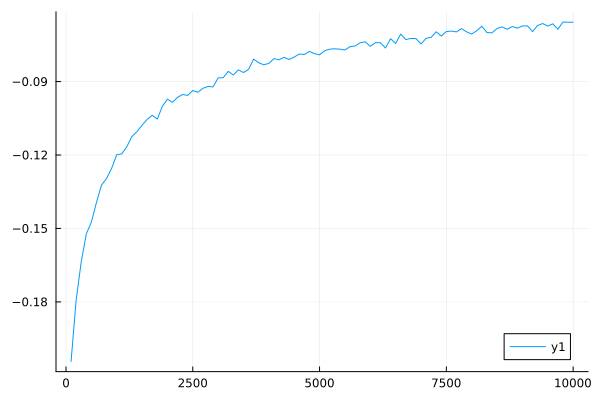

In [14]:
plot(get(history, :lpl))

In [10]:
nrows, ncols = 10, 15
nsteps = 3000
fantasy_F = gpu(zeros(nrows*ncols, nsteps))
fantasy_x = gpu(bitrand(28,28,nrows*ncols))
fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
@time for t in 2:nsteps
    fantasy_x .= sample_v_from_v(rbm, fantasy_x)
    fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
end


  0.960667 seconds (1.55 M allocations: 62.712 MiB, 6.37% gc time)


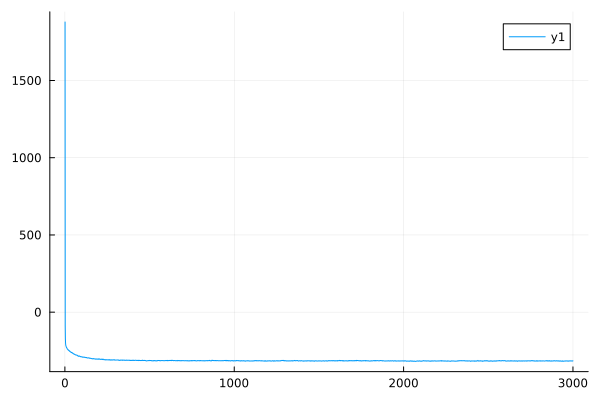

In [11]:
fantasy_F_μ = vec(mean(fantasy_F; dims=1))
fantasy_F_σ = vec(std(fantasy_F; dims=1))

# plot(1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
plot(1:nsteps, fantasy_F_μ)

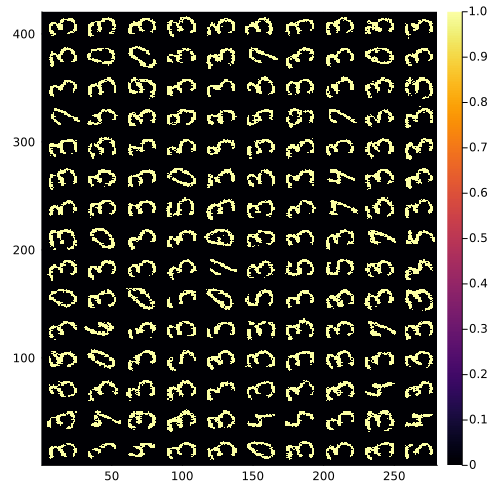

In [12]:


heatmap(cpu(imggrid(reshape(fantasy_x, 28, 28, ncols, nrows))), size=(500,500))

In [17]:
# rbm.w
# J.b = rbm.hidden.θ
# J.a = reshape(rbm.visible.θ,hparams.nv)
# J.w = reshape(rbm.w,hparams.nv,hparams.nh);
rbm.w

28×28×500 CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}:
[:, :, 1] =
 -0.0407723   -0.0614824  …  -0.0256095   -0.0380431  -0.010265
 -0.00174348  -0.033139      -0.0265527   -0.0294422  -0.0250427
 -0.0279114   -0.032582      -0.00103649  -0.019327   -0.0427519
 -0.0210365   -0.0178876     -0.0801641   -0.0184348  -0.0243748
 -0.024581    -0.0311332      0.00679673   0.032752   -0.0313725
 -0.0125087   -0.0183526  …  -0.0115928   -0.0714365  -0.0105323
 -0.0309893   -0.0932896     -0.00475063  -0.0734631  -0.104515
 -0.0262623   -0.156183       0.0532255   -0.0375694  -0.122408
 -0.052867    -0.0881816      0.0835228   -0.0196227  -0.0800421
 -0.0457443   -0.0611621      0.125475     0.020194    0.0190859
 -0.00356904  -0.0521365  …   0.122481     0.0844636   0.121054
 -0.0401304   -0.0232132      0.149164     0.108423    0.108906
 -0.0222993   -0.0710963      0.113563     0.144215    0.108033
  ⋮                       ⋱   ⋮                       
 -0.0419672   -0.208854      -1.44278   

In [16]:
include("../therm.jl")

┌ Warning: Assignment to `rbm` in soft scope is ambiguous because a global variable by the same name exists: `rbm` will be treated as a new local. Disambiguate by using `local rbm` to suppress this warning or `global rbm` to assign to the existing global variable.
└ @ ~/Projects/RBM/therm.jl:181
┌ Warning: Assignment to `hparams` in soft scope is ambiguous because a global variable by the same name exists: `hparams` will be treated as a new local. Disambiguate by using `local hparams` to suppress this warning or `global hparams` to assign to the existing global variable.
└ @ ~/Projects/RBM/therm.jl:181


In [19]:
rbmJ, J, m, hparams, rbmZJ = initModel(nv=28*28, nh=500, batch_size=500, lr=1.5, t=10, gpu_usage = true, optType="Adam")
opt = initOptW(hparams, J);
J.b = rbm.hidden.θ
J.a = reshape(rbm.visible.θ,28*28)
J.w = reshape(rbm.w,28*28,500);

In [35]:
v = sign.(rand(hparams.nv, 500) .< 0.5) |> cpu ;
h = sign.(rand(hparams.nh, 500) .< 0.5) |> cpu ;
v,h = gibbs_sampling(v,h,J; mcs=500)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 1.0])

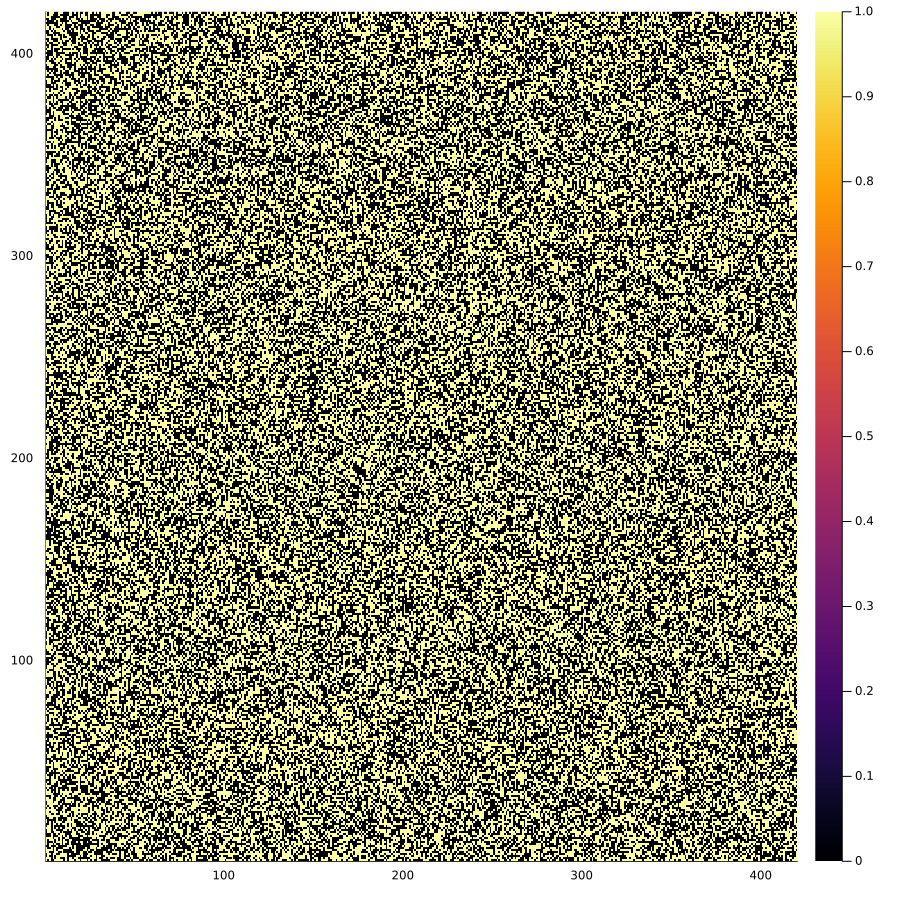

In [34]:
lnum=15
heatmap(cat([cat([reshape(v[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1), size=(900,900))

In [32]:
?rbm

search: rbm rbmJ rbmZJ RBM EnRBM genRBM CudaRBMs set_zero_subnormals



No documentation found.

`rbm` is of type `RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}`.

# Summary

```
struct RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}
```

# Fields

```
visible :: RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}
hidden  :: RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}
w       :: CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}
```


In [25]:
saveModel(rbmJ, J, m, hparams; opt, path = "PCD_test-1", epoch=2)

In [26]:
batchsize = 500 #256
iters = 10000
# history = MVHistory()
rbmJ, J, m, hparams, rbmZJ = initModel(nv=28*28, nh=500, batch_size=500, lr=1.5, t=10, gpu_usage = true, optType="Adam")
opt = initOptW(hparams, J);
@time pcd!(
    rbm, train_x; steps=100, iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            # lpl = mean(log_pseudolikelihood(rbm, train_x))
            # @trace history iter lpl
            J.b = rbm.hidden.θ
            J.a = reshape(rbm.visible.θ,28*28)
            J.w = reshape(rbm.w,28*28,500);
            saveModel(rbmJ, J, m, hparams; opt, path = "PCD_test-1", epoch=iter)
        end
    end
)

578.601766 seconds (314.92 M allocations: 13.536 GiB, 49.73% gc time)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([0.0 0.0 … 6.0f-45 0.0;;; 0.0 0.0 … 0.0 0.0;;; 6.0f-45 0.0 … 0.0 0.0;;; … ;;; 6.0f-45 0.0 … 6.0f-45 0.0;;; 3.40403f-38 0.0 … 6.0f-45 0.0;;; 0.0 0.0 … 0.0 6.0f-45], [0.0 0.0 … 5.63923f-12 0.0;;; 0.0 0.0 … 0.0 0.0;;; 1.26885f-12 0.0 … 0.0 0.0;;; … ;;; 1.0534f-12 0.0 … 1.27266f-12 0.0;;; 1.91156f-9 0.0 … 4.52794f-11 0.0;;; 0.0 0.0 … 0.0 4.83666f-13], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[-2.94907f-5 -0.000265905 … 0.0218898 -0.0306108], Float32[0.00233965 0.00370545 … 0.0130133 0.00849543], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([0.0 0.0 … 6.0f-45 0.0; 0.0 0.0 … 0.0 0.0; … ; 6.0f-45 0.0 … 6.0f-45 0.0; 0.0 0.0 … 0.0 6.0f-45;;; 0.0 0.0 … 2.48006f-40 0.0; 0.0 0.0 … 0.0 0.0; … ; 6.0f-45 0.0 … 6.0f-45 0.0; 0.0 0.0 … 0.0 6.0f-45;;; 0.0 0.0 … 3.33397f-38 0.0; 0.0 0.0 … 0.0 0.0; … ; 6.0f-45 0.0 … 6.0f-45 0.0; 0.0 0.0 … 0.0 6.0f-45;;;

In [24]:
x, y = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);
TS = Test(x,y)
lnum=10

[ Info: 10000


10

In [34]:
# J.w
# reshape(rbm.w,28*28,500)
dev = gpu

gpu (generic function with 13 methods)

In [43]:
J.b = rbm.hidden.θ
J.a = reshape(rbm.visible.θ,28*28)
J.w = reshape(rbm.w,28*28,500);

In [ ]:
saveModel(rbm, J, m, hparams; opt, path = dict["msg"], baseDir = dict["bdir"], epoch)

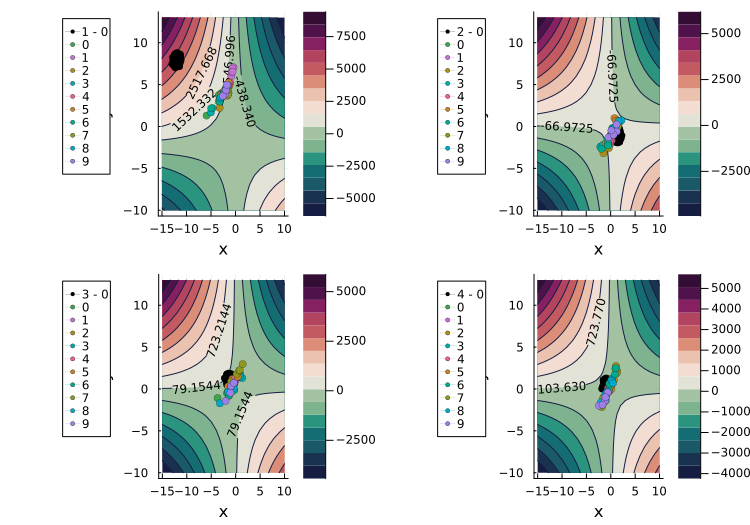

In [90]:
plotLandscapes(rbmJ, J, lnum ; τ=0, kmax=4, TS, dev, hparams)

In [81]:
β=1.0
num = 1000
F = LinearAlgebra.svd(J.w, full=true);
s = Dict()
t = Dict()
v = Dict()
h = Dict()
for j in 0:9
    idx = findall(x->x == j, TS.y) #[1:num]
    vSamp = TS.x[:,idx] |> dev
    num = size(vSamp,2)
    hSamp = Array{Float32}(sign.(rand(hparams.nh, num) |> dev .< σ.(β .* (J.w' * vSamp .+ J.b)))) |> dev ;

    s[string(j)] = cpu(F.U' * vSamp)
    t[string(j)] = cpu(F.Vt * hSamp);
    v[string(j)] = vSamp
    h[string(j)] = hSamp
    # p = plot!(s[i,:], t[i,:], markersize=4, markershapes = :circle, lw=0, markerstrokewidth=0.2, c=:auto, label="$j")
end

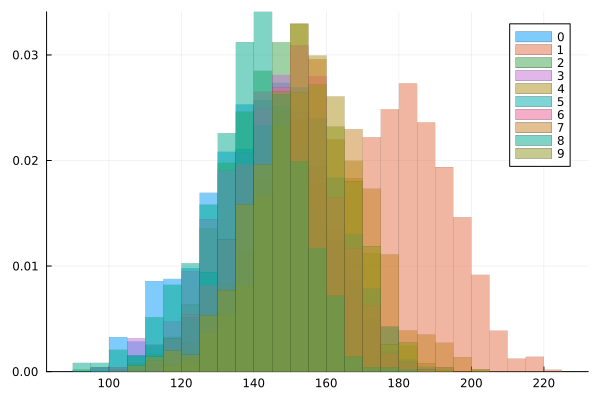

In [82]:
plot()
for j in 0:9
    plot!(diag(t[string(j)]' * t[string(j)]), st=:histogram, fillalpha=0.5, lw=0, label=j, normalized=true)
end
plot!()

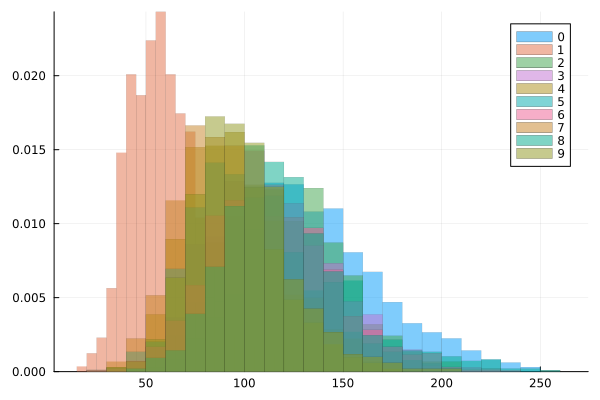

In [83]:
plot()
for j in 0:9
    plot!(diag(s[string(j)]' * s[string(j)]), st=:histogram, fillalpha=0.5, lw=0, label=j, normalized=true)
end
plot!()

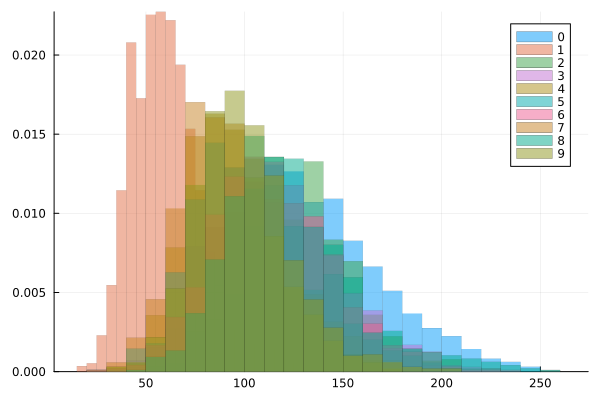

In [84]:
plot()
for j in 0:9
    plot!(diag(v[string(j)]' * v[string(j)]), st=:histogram, fillalpha=0.5, lw=0, label=j, normalized=true)
end
plot!()

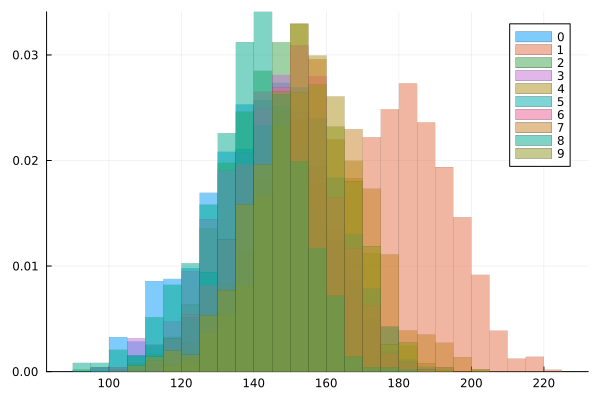

In [87]:
plot()
for j in 0:9
    plot!(diag(h[string(j)]' * h[string(j)]), st=:histogram, fillalpha=0.5, lw=0, label=j, normalized=true)
end
plot!()

###############

In [29]:
# import Makie
# import CairoMakie
import MLDatasets
using Statistics: mean, std, var
using Random: bitrand
using ValueHistories: MVHistory, @trace
using RestrictedBoltzmannMachines: BinaryRBM, sample_from_inputs,
    initialize!, log_pseudolikelihood, pcd!, free_energy, sample_v_from_v
using Plots

using CudaRBMs: cpu, gpu
using CUDA

In [48]:
imggrid(A::AbstractArray{<:Any,4}) =
    reshape(permutedims(A, (1,3,2,4)), size(A,1)*size(A,3), size(A,2)*size(A,4))

imggrid (generic function with 1 method)

In [30]:
Float = Float32
train_x = MLDatasets.MNIST(split=:train)[:].features
train_y = MLDatasets.MNIST(split=:train)[:].targets
# train_x = Array{Float}(train_x[:, :, train_y .== 0] .≥ 0.5);
train_x = CuArray{Float}(train_x[:, :, train_y .== 0] .≥ 0.5);

In [43]:
nrows, ncols = 10, 15
lnum = 10
samp = train_x[:,:,1:100] |> cpu;

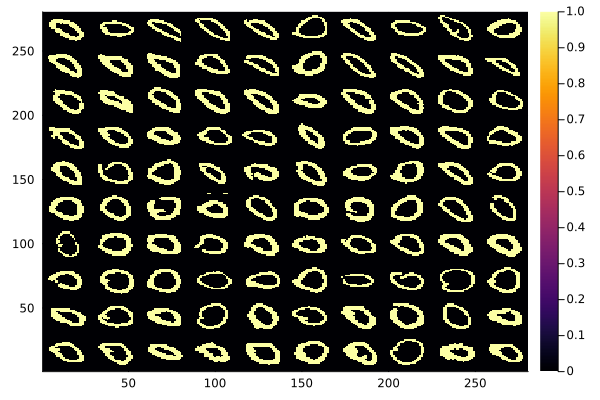

In [32]:
heatmap(cat([cat([samp[:,:,i+j*lnum] for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [33]:
# rbm = BinaryRBM(Float, (28,28), 400)
rbm = gpu(BinaryRBM(Float, (28,28), 400))
initialize!(rbm, train_x) # match single-site statistics


RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}(RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}([-13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; … ;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551]), RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}(Float32[0.0 0.0 … 0.0 0.0]), [-0.0070385453 -0.01879656 … 0.005937164 0.0023454519; 0.008564193 -0.00035005086 … 0.009737052 -0.0015637086; … ; 0.0025739742 0.016190372 … 0.003714579 -0.010958271; -0.0038490738 0.014161518 … 0.0026757235 0.00043587195;;; -0.0027011693 0.0023952646 … 0.008711701 -0.002356749; 0.00011

In [34]:
println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fcaa34e36c0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


  4.200990 seconds (5.60 M allocations: 394.641 MiB, 3.51% gc time)
log(PL) = -0.25752798


In [35]:
batchsize = 256
iters = 10000
history = MVHistory()
@time pcd!(
    rbm, train_x; iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            lpl = mean(log_pseudolikelihood(rbm, train_x))
            @trace history iter lpl
        end
    end
)


 40.067525 seconds (45.92 M allocations: 3.151 GiB, 3.03% gc time, 0.18% compilation time)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 0.0 … 0.0 6.0f-45;;; 0.0 6.0f-45 … 6.0f-45 6.0f-45;;; … ;;; 6.64849f-38 6.0f-45 … 6.0f-45 6.0f-45;;; 9.19575f-10 6.0f-45 … 6.0f-45 3.06842f-6;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45], [1.05416f-9 3.4483f-10 … 1.26197f-9 1.02254f-10;;; 1.14036f-10 0.0 … 0.0 4.28871f-10;;; 0.0 4.36026f-9 … 5.4063f-11 3.88776f-10;;; … ;;; 7.42321f-9 1.68951f-9 … 6.1086f-11 3.32273f-12;;; 1.34918f-8 1.10997f-10 … 8.35367f-13 1.47032f-8;;; 1.08247f-12 1.6926f-11 … 2.78507f-12 6.46661f-11], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[0.018771 -0.0141754 … -0.00606035 -0.00745173], Float32[0.0188829 0.00127452 … 0.00223204 0.00101674], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 8.69161f-12 6.0f-45; 6.0f-45 0.0 … 6.0f-45 6.0f-45; … ; 6.0f-45 0.0 … 6.0f-45 6.0f-45; 6.0f-45 6.0f-45 … 2.03256f-20 6.

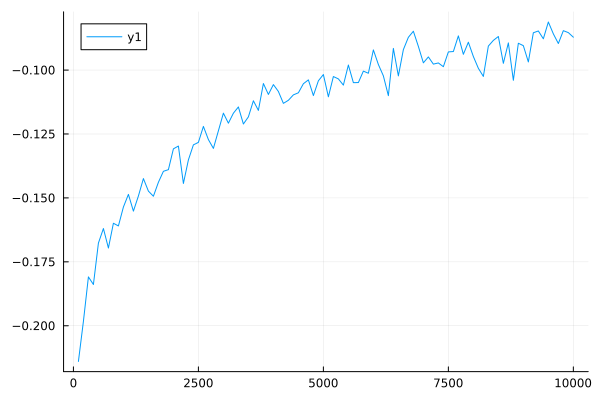

In [40]:
plot(get(history, :lpl))

In [45]:
nsteps = 3000
fantasy_F = gpu(zeros(nrows*ncols, nsteps))
fantasy_x = gpu(bitrand(28,28,nrows*ncols))
fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
@time for t in 2:nsteps
    fantasy_x .= sample_v_from_v(rbm, fantasy_x)
    fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
end


  0.975290 seconds (1.48 M allocations: 60.398 MiB)


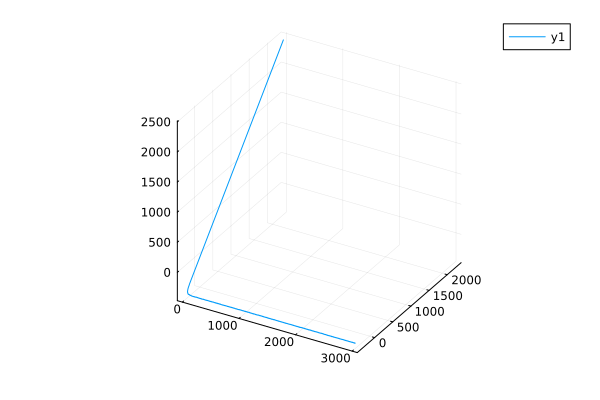

In [46]:
fantasy_F_μ = vec(mean(fantasy_F; dims=1))
fantasy_F_σ = vec(std(fantasy_F; dims=1))
# Makie.band!(ax, 1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
# Makie.lines!(ax, 1:nsteps, fantasy_F_μ)
plot(1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)

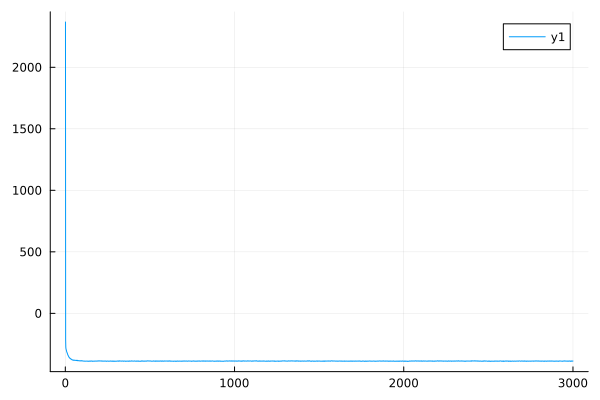

In [47]:
plot(1:nsteps, fantasy_F_μ)

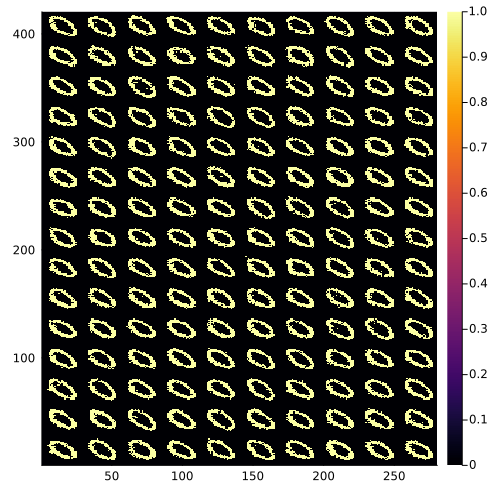

In [53]:
heatmap(cpu(imggrid(reshape(fantasy_x, 28, 28, ncols, nrows))), size=(500,500))

In [4]:
#AIS

In [6]:
import MLDatasets
# import Makie
# import CairoMakie
import RestrictedBoltzmannMachines as RBMs
using Statistics: mean, std, middle
using ValueHistories: MVHistory
using RestrictedBoltzmannMachines: Binary, BinaryRBM, initialize!, pcd!,
    aise, raise, logmeanexp, logstdexp, sample_v_from_v


In [119]:
Float = Float32
train_x = MLDatasets.MNIST(split=:train)[:].features
train_y = MLDatasets.MNIST(split=:train)[:].targets;
train_x = Array{Float}(train_x[:, :, :] .> 0.5);


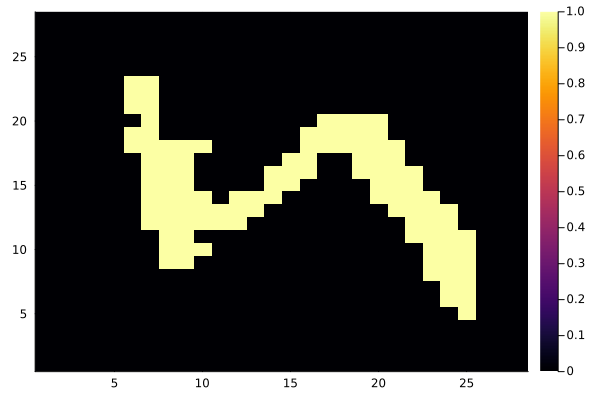

In [120]:
heatmap(train_x[:,:,1])

In [42]:
rbm = CudaRBMs.gpu(BinaryRBM(Float32, (28,28), 500))

RestrictedBoltzmannMachines.RBM{Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}(Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}([0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0]), Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}(Float32[0.0 0.0 … 0.0 0.0]), [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [45]:
initialize!(rbm, train_x)

RestrictedBoltzmannMachines.RBM{Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}(Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}([-13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; … ;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551]), Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}(Float32[0.0 0.0 … 0.0 0.0]), [0.0022716213 0.012293083 … 0.0074191596 -0.0029345267; -0.0003667957 0.002097354 … 0.0035026527 -0.0013216038; … ; 0.009131995 -0.012847659 … -0.0020369953 0.007767138; 0.00052672887 0.007560793 … 0.007011729 0.00100179;;; 0.008205892 -0.007981869 … 0.0025649196 -0.002103589; -0.0019356334 -0.006903798 … -0.010949809 0.0030434926; … ; -0.0047458746 0.012653037 … 0.006161957 0.008529944; 0.0040897

In [46]:
include("utils/train.jl")


In [173]:

println("log(PL) = ", mean(@time log_pseudolikelihood(CudaRBMs.cpu(rbm), train_x)))
# train_x
# rbm

  5.003202 seconds (180.17 k allocations: 649.020 MiB, 2.53% gc time)
log(PL) = -0.06048756


In [175]:
mean(log_pseudolikelihood(CudaRBMs.cpu(rbm), train_x))

-0.05931329f0

In [159]:
Float = Float32
train_x = MLDatasets.MNIST(split=:train)[:].features
train_y = MLDatasets.MNIST(split=:train)[:].targets;
train_x = Array{Float}(train_x[:, :, :] .> 0.5);

modelName = "PCD-500-replica2"

# rbm, J, m, hparams, opt = loadModel(modelName, gpu);


# for nbetas in ndists
#     push!(R_ais,
#         @time aise(rbm; nbetas, nsamples, init)
#     )
#     push!(R_rev,
#         @time raise(rbm; nbetas, init, v=v[:,:,rand(1:size(v, 3), nsamples)])
#     )
# end


function loadLandscapes(PATH = "/home/javier/Projects/RBM/Results/",  modelname = "PCD-500-replica2"; l=30, nv=28*28, nh=500, nbetas = 10_000)
    s = size(readdir("$(PATH)/models/$(modelname)/J"),1)
    nsamples=100
    # ndists = [10, 100, 1000, 10_000, 100_000]
    # nbetas = 10_000
    R_ais = Vector{Float64}[]
    R_rev = Vector{Float64}[]

    Δidx = s >= l ? Int(floor(s/l)) : 1
    for i in 1:min(l,s)
        idx = Δidx*i
        @info idx
        
        J = load("$(PATH)/models/$(modelname)/J/J_$(idx).jld", "J")
        J.w = gpu(J.w)
        J.b = gpu(J.b)
        J.a = gpu(J.a)
        
        rbm = RestrictedBoltzmannMachines.RBM(Binary(; θ=reshape(J.a,28,28)), Binary(; θ=J.b), reshape(J.w, 28,28,500))
        v = train_x[:, :, rand(1:size(train_x, 3), 1000)] |> gpu
        v = sample_v_from_v(rbm, v; steps=1000);

        init = initialize!(Binary(; θ = zero(rbm.visible.θ)), v)
        
        push!(R_ais, aise(rbm; nbetas, nsamples, init) )
        push!(R_rev, raise(rbm; nbetas, init, v=v[:,:,rand(1:size(v, 3), nsamples)]) )
        
    end

    return R_ais, R_rev
end

loadLandscapes (generic function with 3 methods)

In [160]:
@time R_ais, R_rev = loadLandscapes(l=10, nbetas=100_000)

[ Info: 10
[ Info: 20
[ Info: 30
[ Info: 40
[ Info: 50
[ Info: 60
[ Info: 70
[ Info: 80
[ Info: 90
[ Info: 100


2914.888498 seconds (2.23 G allocations: 488.254 GiB, 14.06% gc time)


([[407.3104946214314, 407.4941243785329, 407.5567756199825, 407.16422156633223, 407.5613837647891, 407.17940600607506, 407.30301397474227, 406.9496232278314, 407.51801031400123, 406.98502216815325  …  407.4686760104726, 407.18406504171725, 407.3949177990353, 408.1665377316839, 407.04116065296927, 407.2609639743386, 407.6775192038722, 407.3667274016127, 407.62253781597104, 407.82001396384396], [414.1592135180802, 414.96328589552866, 414.1176202917746, 414.28826468827344, 414.9631162073103, 415.2976909753835, 415.141869011699, 414.863383575562, 415.3371086398438, 415.14416991534995  …  414.10554670997533, 414.9325570206629, 414.3690415994194, 414.64134176750963, 414.95008443026575, 415.1526048405358, 414.164050734527, 413.89566105173793, 414.3007495935851, 414.49563030310173], [423.22478346437964, 422.57317258360246, 423.83411041414246, 419.90792455361805, 420.173558227013, 421.80826775010314, 421.62942598256524, 421.30511222995915, 422.607154580774, 423.5600409216889  …  422.98526916828

In [139]:
# nsamples=100
# ndists = [10, 100, 1000, 10_000, 100_000]
# R_ais = Vector{Float64}[]
# R_rev = Vector{Float64}[]
# init = initialize!(Binary(; θ = zero(rbm.visible.θ)), v)

# for nbetas in ndists
#     push!(R_ais,
#         @time aise(rbm; nbetas, nsamples, init)
#     )
#     push!(R_rev,
#         @time raise(rbm; nbetas, init, v=v[:,:,rand(1:size(v, 3), nsamples)])
#     )
# end


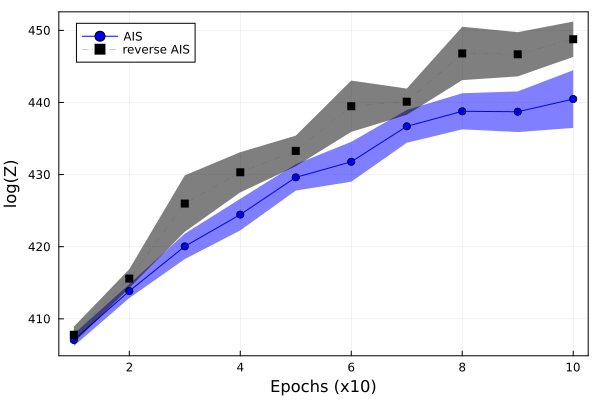

In [158]:
plot( mean.(R_ais), ribbon=std.(R_ais), xscale=:identity, color=:blue, label="AIS", markershape=:circle)
plot!( mean.(R_rev), ribbon=std.(R_rev), color=:black, label="reverse AIS", s=:auto, markershapes = :square, lw=0, markerstrokewidth=0)
plot!(xlabel="Epochs (x10)", frame=:box, ylabel="log(Z)")

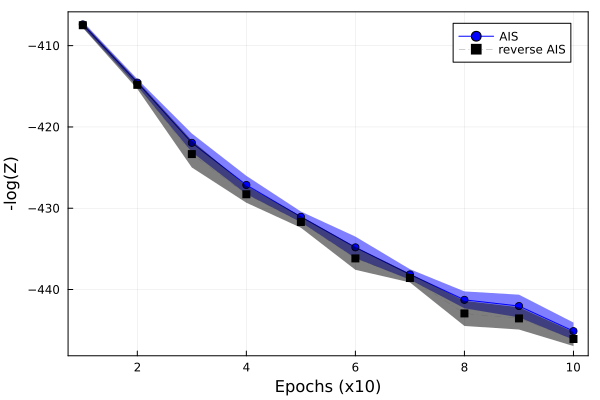

In [164]:
plot( -mean.(R_ais), ribbon=std.(R_ais), xscale=:identity, color=:blue, label="AIS", markershape=:circle)
plot!( -mean.(R_rev), ribbon=std.(R_rev), color=:black, label="reverse AIS", s=:auto, markershapes = :square, lw=0, markerstrokewidth=0)
plot!(xlabel="Epochs (x10)", frame=:box, ylabel="-log(Z)")

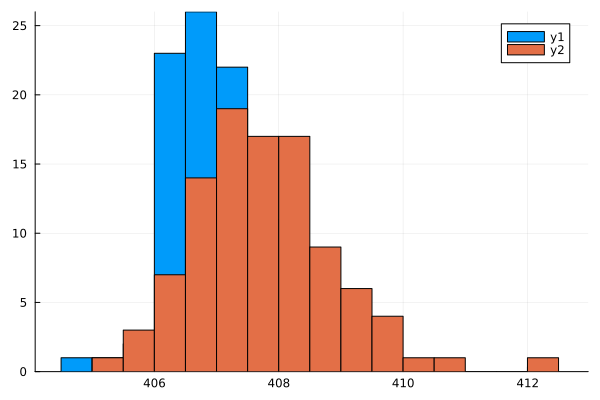

In [149]:
plot(R_ais[1], st=:histogram, bins=20)
plot!(R_rev[1], st=:histogram, bins=20)

In [140]:
R_ais

10-element Vector{Vector{Float64}}:
 [406.0978540697002, 409.6898104330537, 406.10462837354976, 406.0910372708316, 407.1371399953183, 406.30773624071145, 405.6519991391074, 405.82322157959044, 406.4305185619193, 407.08187420961315  …  406.9889963662082, 407.5443295101114, 406.7635745693943, 406.73070601460586, 406.023227981291, 407.84443213103845, 407.30430316383985, 406.2207436314953, 407.8194616488766, 408.21669324805185]
 [416.72225494958997, 413.9956280192392, 414.23354499137, 413.8201594864732, 415.86103921003905, 413.7476424468586, 412.3314660870548, 412.9709081789898, 414.1133798840163, 413.30891080685825  …  412.2318692970818, 414.348945679787, 413.8709181687354, 414.37947626272904, 414.3371402292386, 413.5493727386221, 413.8964851120785, 416.61504209158153, 414.6408118797714, 413.7063223594222]
 [419.51417274237247, 418.02342437419765, 420.4805308436111, 420.29424787855845, 419.97305652475745, 421.3920588520382, 420.8939784248337, 419.16639532297177, 419.90044573679177, 418.01